From https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

About this dataset
Age : Age of the patient

Sex : Sex of the patient

exang: exercise induced angina (1 = yes; 0 = no)

ca: number of major vessels (0-3)

cp : Chest Pain type chest pain type

Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4: asymptomatic
trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results

Value 0: normal
Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach : maximum heart rate achieved

target/output : 0= less chance of heart attack 1= more chance of heart attack

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot
import sklearn as sk
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# importing the data to a dataframe 
df = pd.read_csv("../data/heart-attack-prediction/heart.csv") 
SAMPLE_SIZE = len(df.index)

In [4]:
#Lets use output or target as preiction label

# Specify the data 3 skip the quality out for y
X= df.loc[:, :'thall']
y = df.loc[:,['output']]
print(X.head())
print(y.head())
print("shape of X",X.to_numpy().shape)
print("shape of y",y.to_numpy().shape)

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  
0    0      1  
1    0      2  
2    0      2  
3    0      2  
4    0      2  
   output
0       1
1       1
2       1
3       1
4       1
shape of X (303, 13)
shape of y (303, 1)


In [5]:
# Scale the Feature data
scaler = sk.preprocessing.StandardScaler().fit(X)
X_s = scaler.transform(X)
# Convert the  validation data 
num_classes = 2
y_s = keras.utils.to_categorical(y, num_classes)

In [6]:
print("shape of X_s",X_s.shape)
print("shape of y_s",y_s.shape)
print("X_s",X_s[1])
print("y_s",y_s[1])
# Preprocess the data (these are NumPy arrays)
X_s = X_s.reshape(SAMPLE_SIZE, 13).astype("float32") 
y_s = y_s.reshape(SAMPLE_SIZE, 2).astype("float32") 
print("shape of X_s",X_s.shape)
print("shape of y_s",y_s.shape)
print("X_s",X_s[1])
print("y_s",y_s[1])

shape of X_s (303, 13)
shape of y_s (303, 2)
X_s [-1.91531289  0.68100522  1.00257707 -0.09273778  0.07219949 -0.41763453
  0.89896224  1.63347147 -0.69663055  2.12257273 -2.27457861 -0.71442887
 -0.51292188]
y_s [0. 1.]
shape of X_s (303, 13)
shape of y_s (303, 2)
X_s [-1.9153129   0.68100524  1.0025771  -0.09273779  0.07219949 -0.41763455
  0.89896226  1.6334715  -0.69663054  2.1225727  -2.2745786  -0.71442884
 -0.51292187]
y_s [0. 1.]


In [7]:
dataset = tf.data.Dataset.from_tensor_slices((X_s, y_s))

In [8]:
train_size = int(0.7 * SAMPLE_SIZE)
val_size = int(0.15 * SAMPLE_SIZE)
test_size = int(0.15 * SAMPLE_SIZE)
print("train_size=",train_size,"val_size=",val_size,"test_size=",test_size)
dataset = dataset.shuffle(SAMPLE_SIZE)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

# for tf data set batch size is given here
batch_size = 128
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

train_size= 212 val_size= 45 test_size= 45


In [9]:
optimizer = "adam"
loss="categorical_crossentropy" 
mertics_key = "accuracy"
epochs = 100 

In [10]:
# Try to create a model via Optuna
import optuna

In [11]:
N_TRAIN_EXAMPLES = train_size
N_VALID_EXAMPLES = val_size
BATCHSIZE = 128
CLASSES = 2
EPOCHS = 1

tf.keras.backend.clear_session()
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 5)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(CLASSES,activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    return model

In [12]:
def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer


In [13]:
def get_test_dataset():
    return test_dataset
def get_val_dataset():
    return val_dataset

In [14]:

def objective(trial):
    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics="accuracy")
    history =model.fit(train_dataset, epochs=1)
    test_dataset = get_test_dataset()
    score = model.evaluate(test_dataset, verbose = 1) 
    print('Test accuracy:', score[1])
    return score[1]

study = optuna.create_study()
study.optimize(objective, n_trials=2)
    


[I 2021-06-29 13:55:27,850] A new study created in memory with name: no-name-34588d56-39bd-44ae-b1ed-0e870323c273


1/1 [==============================] - 0s 115ms/step - loss: 0.7965 - accuracy: 0.3778


[I 2021-06-29 13:55:28,463] Trial 0 finished with value: 0.3777777850627899 and parameters: {'n_layers': 3, 'weight_decay': 1.0072094079716978e-10, 'n_units_l0': 6, 'n_units_l1': 4, 'n_units_l2': 34, 'optimizer': 'Adam', 'adam_learning_rate': 0.00010482408810682922}. Best is trial 0 with value: 0.3777777850627899.


Test accuracy: 0.3777777850627899
1/1 [==============================] - 0s 107ms/step - loss: 0.7046 - accuracy: 0.5111


[I 2021-06-29 13:55:28,972] Trial 1 finished with value: 0.5111111402511597 and parameters: {'n_layers': 5, 'weight_decay': 0.00016504635346768824, 'n_units_l0': 89, 'n_units_l1': 6, 'n_units_l2': 113, 'n_units_l3': 13, 'n_units_l4': 12, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09299966890820761, 'sgd_opt_momentum': 0.00010938469744323886}. Best is trial 0 with value: 0.3777777850627899.


Test accuracy: 0.5111111402511597


In [16]:

def objective(trial):
    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics="accuracy")
    history =model.fit(train_dataset, epochs=1)
    test_dataset = get_test_dataset()
    score = model.evaluate(test_dataset, verbose = 1) 
    print('Test accuracy:', score[1])
    return score[1]

In [17]:

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-06-29 13:55:48,063] A new study created in memory with name: no-name-ed7e758f-0f53-4632-85f0-241274b1c1d6


1/1 [==============================] - 0s 118ms/step - loss: 0.6954 - accuracy: 0.4667


[I 2021-06-29 13:55:48,579] Trial 0 finished with value: 0.46666666865348816 and parameters: {'n_layers': 5, 'weight_decay': 2.097069743363933e-05, 'n_units_l0': 5, 'n_units_l1': 10, 'n_units_l2': 98, 'n_units_l3': 4, 'n_units_l4': 35, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0004465902881201786, 'sgd_opt_momentum': 0.02720560514327121}. Best is trial 0 with value: 0.46666666865348816.


Test accuracy: 0.46666666865348816
1/1 [==============================] - 0s 105ms/step - loss: 0.9757 - accuracy: 0.4444


[I 2021-06-29 13:55:49,098] Trial 1 finished with value: 0.4444444477558136 and parameters: {'n_layers': 5, 'weight_decay': 5.899042992853249e-05, 'n_units_l0': 17, 'n_units_l1': 38, 'n_units_l2': 13, 'n_units_l3': 101, 'n_units_l4': 93, 'optimizer': 'Adam', 'adam_learning_rate': 0.08307343956908028}. Best is trial 0 with value: 0.46666666865348816.


Test accuracy: 0.4444444477558136
1/1 [==============================] - 0s 94ms/step - loss: 0.7542 - accuracy: 0.3111


[I 2021-06-29 13:55:49,530] Trial 2 finished with value: 0.31111112236976624 and parameters: {'n_layers': 3, 'weight_decay': 5.3535183629425344e-08, 'n_units_l0': 9, 'n_units_l1': 22, 'n_units_l2': 73, 'optimizer': 'Adam', 'adam_learning_rate': 1.314438010649206e-05}. Best is trial 0 with value: 0.46666666865348816.


Test accuracy: 0.31111112236976624
1/1 [==============================] - 0s 87ms/step - loss: 0.6337 - accuracy: 0.6444


[I 2021-06-29 13:55:50,038] Trial 3 finished with value: 0.644444465637207 and parameters: {'n_layers': 1, 'weight_decay': 8.412517170765262e-05, 'n_units_l0': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005814825383577668, 'rmsprop_decay': 0.9778544982759675, 'rmsprop_momentum': 4.840632462840496e-05}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.644444465637207
1/1 [==============================] - 0s 78ms/step - loss: 0.6443 - accuracy: 0.6444


[I 2021-06-29 13:55:50,350] Trial 4 finished with value: 0.644444465637207 and parameters: {'n_layers': 1, 'weight_decay': 1.4845009308249751e-09, 'n_units_l0': 51, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00028880604830479697, 'sgd_opt_momentum': 0.0017847941310494874}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.644444465637207
1/1 [==============================] - 0s 116ms/step - loss: 0.7215 - accuracy: 0.6000


[I 2021-06-29 13:55:50,860] Trial 5 finished with value: 0.6000000238418579 and parameters: {'n_layers': 5, 'weight_decay': 0.0003000506570416857, 'n_units_l0': 4, 'n_units_l1': 18, 'n_units_l2': 26, 'n_units_l3': 32, 'n_units_l4': 30, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.029341682984935568, 'sgd_opt_momentum': 0.017288722969594415}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 111ms/step - loss: 0.7248 - accuracy: 0.5333


[I 2021-06-29 13:55:51,358] Trial 6 finished with value: 0.5333333611488342 and parameters: {'n_layers': 4, 'weight_decay': 1.1850591089693354e-10, 'n_units_l0': 4, 'n_units_l1': 86, 'n_units_l2': 43, 'n_units_l3': 4, 'optimizer': 'Adam', 'adam_learning_rate': 0.005125579312018568}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.5333333611488342
1/1 [==============================] - 0s 97ms/step - loss: 0.7469 - accuracy: 0.4000


[I 2021-06-29 13:55:51,790] Trial 7 finished with value: 0.4000000059604645 and parameters: {'n_layers': 3, 'weight_decay': 4.181470569892273e-05, 'n_units_l0': 37, 'n_units_l1': 45, 'n_units_l2': 30, 'optimizer': 'Adam', 'adam_learning_rate': 0.0007466541780015312}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.4000000059604645
1/1 [==============================] - 0s 110ms/step - loss: 0.7068 - accuracy: 0.4444


[I 2021-06-29 13:55:52,282] Trial 8 finished with value: 0.4444444477558136 and parameters: {'n_layers': 5, 'weight_decay': 5.703293477786893e-07, 'n_units_l0': 19, 'n_units_l1': 33, 'n_units_l2': 111, 'n_units_l3': 16, 'n_units_l4': 25, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012864442897318425, 'sgd_opt_momentum': 0.028548148274941166}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.4444444477558136
1/1 [==============================] - 0s 99ms/step - loss: 0.6934 - accuracy: 0.5111


[I 2021-06-29 13:55:52,763] Trial 9 finished with value: 0.5111111402511597 and parameters: {'n_layers': 4, 'weight_decay': 1.5573488365687197e-07, 'n_units_l0': 4, 'n_units_l1': 5, 'n_units_l2': 41, 'n_units_l3': 16, 'optimizer': 'Adam', 'adam_learning_rate': 0.0012633966901742948}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.5111111402511597
1/1 [==============================] - 0s 88ms/step - loss: 0.7767 - accuracy: 0.6000


[I 2021-06-29 13:55:53,138] Trial 10 finished with value: 0.6000000238418579 and parameters: {'n_layers': 1, 'weight_decay': 2.34969884915034e-06, 'n_units_l0': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.008278336595435608, 'rmsprop_decay': 0.9859002193844528, 'rmsprop_momentum': 5.196406476627e-05}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 82ms/step - loss: 0.8716 - accuracy: 0.4000


[I 2021-06-29 13:55:53,497] Trial 11 finished with value: 0.4000000059604645 and parameters: {'n_layers': 1, 'weight_decay': 8.322228275867809e-10, 'n_units_l0': 127, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 6.087654770166406e-05, 'rmsprop_decay': 0.9583802612395911, 'rmsprop_momentum': 1.2021641027921612e-05}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.4000000059604645
1/1 [==============================] - 0s 88ms/step - loss: 100.0479 - accuracy: 0.4667


[I 2021-06-29 13:55:53,899] Trial 12 finished with value: 0.46666666865348816 and parameters: {'n_layers': 2, 'weight_decay': 5.9955182371291316e-09, 'n_units_l0': 58, 'n_units_l1': 104, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.09222198929549548, 'rmsprop_decay': 0.8576105497640402, 'rmsprop_momentum': 0.054763708001886624}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.46666666865348816
1/1 [==============================] - 0s 94ms/step - loss: 1.0764 - accuracy: 0.3333


[I 2021-06-29 13:55:54,507] Trial 13 finished with value: 0.3333333432674408 and parameters: {'n_layers': 2, 'weight_decay': 0.0009702867327131131, 'n_units_l0': 87, 'n_units_l1': 4, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.4590647746964623e-05, 'sgd_opt_momentum': 7.809488709078597e-05}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.3333333432674408
1/1 [==============================] - 0s 83ms/step - loss: 0.7596 - accuracy: 0.5556


[I 2021-06-29 13:55:54,868] Trial 14 finished with value: 0.5555555820465088 and parameters: {'n_layers': 1, 'weight_decay': 1.0542804193510633e-08, 'n_units_l0': 47, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0011144832055777162, 'rmsprop_decay': 0.9134992956368762, 'rmsprop_momentum': 0.000546609947585991}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.5555555820465088
1/1 [==============================] - 0s 91ms/step - loss: 0.8206 - accuracy: 0.4444


[I 2021-06-29 13:55:55,265] Trial 15 finished with value: 0.4444444477558136 and parameters: {'n_layers': 2, 'weight_decay': 1.0737967282063592e-10, 'n_units_l0': 27, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00012863854860298767, 'sgd_opt_momentum': 0.00018313656350654988}. Best is trial 3 with value: 0.644444465637207.


Test accuracy: 0.4444444477558136
1/1 [==============================] - 0s 81ms/step - loss: 0.5171 - accuracy: 0.7778


[I 2021-06-29 13:55:55,627] Trial 16 finished with value: 0.7777777910232544 and parameters: {'n_layers': 1, 'weight_decay': 1.4897166144963342e-06, 'n_units_l0': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.038141364591284595, 'rmsprop_decay': 0.9338302341692127, 'rmsprop_momentum': 0.00022237329707977082}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 88ms/step - loss: 1.7287 - accuracy: 0.6000


[I 2021-06-29 13:55:56,027] Trial 17 finished with value: 0.6000000238418579 and parameters: {'n_layers': 2, 'weight_decay': 3.1449501299117346e-06, 'n_units_l0': 9, 'n_units_l1': 66, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.044309221053864686, 'rmsprop_decay': 0.9316123148795465, 'rmsprop_momentum': 0.00024363930054034503}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 80ms/step - loss: 1.1640 - accuracy: 0.6000


[I 2021-06-29 13:55:56,395] Trial 18 finished with value: 0.6000000238418579 and parameters: {'n_layers': 1, 'weight_decay': 7.4268461312204195e-06, 'n_units_l0': 13, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005014863663038926, 'rmsprop_decay': 0.9898552965099161, 'rmsprop_momentum': 0.00653133780172655}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 86ms/step - loss: 0.6046 - accuracy: 0.6667


[I 2021-06-29 13:55:56,792] Trial 19 finished with value: 0.6666666865348816 and parameters: {'n_layers': 2, 'weight_decay': 0.00021555861395754574, 'n_units_l0': 6, 'n_units_l1': 13, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.014302138210726196, 'rmsprop_decay': 0.9000617261502337, 'rmsprop_momentum': 5.081779828917393e-05}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.6666666865348816
1/1 [==============================] - 0s 89ms/step - loss: 0.5645 - accuracy: 0.7111


[I 2021-06-29 13:55:57,182] Trial 20 finished with value: 0.7111111283302307 and parameters: {'n_layers': 2, 'weight_decay': 0.0008735217873040426, 'n_units_l0': 6, 'n_units_l1': 11, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.08789644208834198, 'rmsprop_decay': 0.8886575957809131, 'rmsprop_momentum': 7.140000454618838e-05}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.7111111283302307
1/1 [==============================] - 0s 92ms/step - loss: 1.0553 - accuracy: 0.3556


[I 2021-06-29 13:55:57,586] Trial 21 finished with value: 0.35555556416511536 and parameters: {'n_layers': 2, 'weight_decay': 0.000877157289528058, 'n_units_l0': 6, 'n_units_l1': 12, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.07940934179064131, 'rmsprop_decay': 0.8860800605735807, 'rmsprop_momentum': 7.967839241851356e-05}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.35555556416511536
1/1 [==============================] - 0s 88ms/step - loss: 0.5894 - accuracy: 0.7111


[I 2021-06-29 13:55:58,012] Trial 22 finished with value: 0.7111111283302307 and parameters: {'n_layers': 2, 'weight_decay': 0.00022998713819752197, 'n_units_l0': 13, 'n_units_l1': 6, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.02546091108016606, 'rmsprop_decay': 0.897155589702937, 'rmsprop_momentum': 1.359673567766929e-05}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.7111111283302307
1/1 [==============================] - 0s 100ms/step - loss: 0.6854 - accuracy: 0.6444


[I 2021-06-29 13:55:58,479] Trial 23 finished with value: 0.644444465637207 and parameters: {'n_layers': 3, 'weight_decay': 0.0009556454538539968, 'n_units_l0': 13, 'n_units_l1': 6, 'n_units_l2': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.07923967796498173, 'rmsprop_decay': 0.8726852637103348, 'rmsprop_momentum': 1.0831288353436886e-05}. Best is trial 16 with value: 0.7777777910232544.


Test accuracy: 0.644444465637207
1/1 [==============================] - 0s 101ms/step - loss: 0.5770 - accuracy: 0.8222


[I 2021-06-29 13:55:59,134] Trial 24 finished with value: 0.8222222328186035 and parameters: {'n_layers': 2, 'weight_decay': 0.0002418463813558198, 'n_units_l0': 12, 'n_units_l1': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.029934217982573185, 'rmsprop_decay': 0.9369316280749477, 'rmsprop_momentum': 0.00044551721238774317}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 101ms/step - loss: 0.6437 - accuracy: 0.7111


[I 2021-06-29 13:55:59,613] Trial 25 finished with value: 0.7111111283302307 and parameters: {'n_layers': 3, 'weight_decay': 7.96040022925726e-06, 'n_units_l0': 13, 'n_units_l1': 4, 'n_units_l2': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.017424631973993045, 'rmsprop_decay': 0.9390388528081611, 'rmsprop_momentum': 0.0026777090082433057}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.7111111283302307
1/1 [==============================] - 0s 106ms/step - loss: 0.6662 - accuracy: 0.6444


[I 2021-06-29 13:56:00,128] Trial 26 finished with value: 0.644444465637207 and parameters: {'n_layers': 4, 'weight_decay': 9.70963539884481e-07, 'n_units_l0': 24, 'n_units_l1': 4, 'n_units_l2': 4, 'n_units_l3': 114, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0020707529328042396, 'rmsprop_decay': 0.9413413949884805, 'rmsprop_momentum': 0.0028662135163932223}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.644444465637207
1/1 [==============================] - 0s 93ms/step - loss: 0.6870 - accuracy: 0.6000


[I 2021-06-29 13:56:00,585] Trial 27 finished with value: 0.6000000238418579 and parameters: {'n_layers': 3, 'weight_decay': 1.0992613287177784e-05, 'n_units_l0': 17, 'n_units_l1': 4, 'n_units_l2': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.000393020844785539, 'rmsprop_decay': 0.9506095489507141, 'rmsprop_momentum': 0.0017492951810332165}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 86ms/step - loss: 0.6306 - accuracy: 0.4889


[I 2021-06-29 13:56:00,986] Trial 28 finished with value: 0.4888888895511627 and parameters: {'n_layers': 2, 'weight_decay': 0.00024535748188962134, 'n_units_l0': 11, 'n_units_l1': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.026155040930223195, 'rmsprop_decay': 0.919780184967477, 'rmsprop_momentum': 0.0003119089762039249}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.4888888895511627
1/1 [==============================] - 0s 96ms/step - loss: 0.4949 - accuracy: 0.7778


[I 2021-06-29 13:56:01,439] Trial 29 finished with value: 0.7777777910232544 and parameters: {'n_layers': 3, 'weight_decay': 1.710493098394475e-07, 'n_units_l0': 28, 'n_units_l1': 23, 'n_units_l2': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.017788170626732772, 'rmsprop_decay': 0.9634636706599762, 'rmsprop_momentum': 0.012262530647327219}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 103ms/step - loss: 0.7000 - accuracy: 0.3333


[I 2021-06-29 13:56:01,946] Trial 30 finished with value: 0.3333333432674408 and parameters: {'n_layers': 4, 'weight_decay': 1.2530256273969192e-07, 'n_units_l0': 33, 'n_units_l1': 24, 'n_units_l2': 8, 'n_units_l3': 44, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0002931017674617778, 'rmsprop_decay': 0.9688852247070299, 'rmsprop_momentum': 0.018601652439056794}. Best is trial 24 with value: 0.8222222328186035.


Test accuracy: 0.3333333432674408
1/1 [==============================] - 0s 97ms/step - loss: 0.3171 - accuracy: 0.9111


[I 2021-06-29 13:56:02,427] Trial 31 finished with value: 0.9111111164093018 and parameters: {'n_layers': 3, 'weight_decay': 2.611042176329117e-08, 'n_units_l0': 15, 'n_units_l1': 16, 'n_units_l2': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.03136536087969351, 'rmsprop_decay': 0.9067855416819303, 'rmsprop_momentum': 0.0008180453151276501}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.9111111164093018
1/1 [==============================] - 0s 93ms/step - loss: 0.5824 - accuracy: 0.5333


[I 2021-06-29 13:56:02,884] Trial 32 finished with value: 0.5333333611488342 and parameters: {'n_layers': 3, 'weight_decay': 1.9141686156924182e-08, 'n_units_l0': 22, 'n_units_l1': 16, 'n_units_l2': 6, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.037382989815827924, 'rmsprop_decay': 0.9142205569079305, 'rmsprop_momentum': 0.0008869227309072204}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5333333611488342
1/1 [==============================] - 0s 109ms/step - loss: 0.5001 - accuracy: 0.8667


[I 2021-06-29 13:56:03,418] Trial 33 finished with value: 0.8666666746139526 and parameters: {'n_layers': 3, 'weight_decay': 1.069587680193173e-07, 'n_units_l0': 17, 'n_units_l1': 29, 'n_units_l2': 13, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.011928191019492147, 'rmsprop_decay': 0.928810502181186, 'rmsprop_momentum': 0.00023111781342784147}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8666666746139526
1/1 [==============================] - 0s 95ms/step - loss: 0.5641 - accuracy: 0.7111


[I 2021-06-29 13:56:04,122] Trial 34 finished with value: 0.7111111283302307 and parameters: {'n_layers': 3, 'weight_decay': 6.005166998953367e-08, 'n_units_l0': 30, 'n_units_l1': 28, 'n_units_l2': 17, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.003015977206533228, 'rmsprop_decay': 0.9534268390021385, 'rmsprop_momentum': 0.0006425292689025935}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7111111283302307
1/1 [==============================] - 0s 106ms/step - loss: 0.4194 - accuracy: 0.8000


[I 2021-06-29 13:56:04,662] Trial 35 finished with value: 0.800000011920929 and parameters: {'n_layers': 4, 'weight_decay': 3.2347427485228526e-07, 'n_units_l0': 17, 'n_units_l1': 52, 'n_units_l2': 6, 'n_units_l3': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.011796119732172414, 'rmsprop_decay': 0.9264035393934015, 'rmsprop_momentum': 0.0076661199473999605}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 110ms/step - loss: 0.5690 - accuracy: 0.9111


[I 2021-06-29 13:56:05,195] Trial 36 finished with value: 0.9111111164093018 and parameters: {'n_layers': 4, 'weight_decay': 4.326582639510153e-08, 'n_units_l0': 16, 'n_units_l1': 55, 'n_units_l2': 12, 'n_units_l3': 8, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.010253166871433673, 'rmsprop_decay': 0.9269089496080762, 'rmsprop_momentum': 0.0012740777076547369}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.9111111164093018
1/1 [==============================] - 0s 106ms/step - loss: 0.7028 - accuracy: 0.5778


[I 2021-06-29 13:56:05,719] Trial 37 finished with value: 0.5777778029441833 and parameters: {'n_layers': 4, 'weight_decay': 3.0307457467903665e-08, 'n_units_l0': 16, 'n_units_l1': 62, 'n_units_l2': 14, 'n_units_l3': 8, 'optimizer': 'Adam', 'adam_learning_rate': 1.034081127887846e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5777778029441833
1/1 [==============================] - 0s 113ms/step - loss: 0.6879 - accuracy: 0.5778


[I 2021-06-29 13:56:06,294] Trial 38 finished with value: 0.5777778029441833 and parameters: {'n_layers': 5, 'weight_decay': 2.403462021249174e-09, 'n_units_l0': 8, 'n_units_l1': 31, 'n_units_l2': 11, 'n_units_l3': 8, 'n_units_l4': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0033724199212936553, 'rmsprop_decay': 0.914509256185735, 'rmsprop_momentum': 0.00014640316585824993}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5777778029441833
1/1 [==============================] - 0s 102ms/step - loss: 0.5913 - accuracy: 0.6222


[I 2021-06-29 13:56:06,798] Trial 39 finished with value: 0.6222222447395325 and parameters: {'n_layers': 4, 'weight_decay': 4.875609008228421e-09, 'n_units_l0': 21, 'n_units_l1': 41, 'n_units_l2': 18, 'n_units_l3': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.008948439230164973, 'rmsprop_decay': 0.9039813591400653, 'rmsprop_momentum': 0.0014957805154081857}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6222222447395325
1/1 [==============================] - 0s 96ms/step - loss: 0.6812 - accuracy: 0.6889


[I 2021-06-29 13:56:07,299] Trial 40 finished with value: 0.6888889074325562 and parameters: {'n_layers': 3, 'weight_decay': 6.020712364041211e-08, 'n_units_l0': 15, 'n_units_l1': 75, 'n_units_l2': 9, 'optimizer': 'Adam', 'adam_learning_rate': 0.08331529631862922}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6888889074325562
1/1 [==============================] - 0s 107ms/step - loss: 0.5598 - accuracy: 0.8000


[I 2021-06-29 13:56:07,828] Trial 41 finished with value: 0.800000011920929 and parameters: {'n_layers': 4, 'weight_decay': 3.490103327808317e-07, 'n_units_l0': 17, 'n_units_l1': 49, 'n_units_l2': 6, 'n_units_l3': 8, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.009977428219853824, 'rmsprop_decay': 0.9290334157562891, 'rmsprop_momentum': 0.0004209521761788386}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 110ms/step - loss: 0.6424 - accuracy: 0.6889


[I 2021-06-29 13:56:08,569] Trial 42 finished with value: 0.6888889074325562 and parameters: {'n_layers': 4, 'weight_decay': 1.6923119420050468e-08, 'n_units_l0': 20, 'n_units_l1': 54, 'n_units_l2': 6, 'n_units_l3': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00888312949002866, 'rmsprop_decay': 0.9251924836831658, 'rmsprop_momentum': 0.0005115937952312685}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6888889074325562
1/1 [==============================] - 0s 113ms/step - loss: 0.5787 - accuracy: 0.6889


[I 2021-06-29 13:56:09,167] Trial 43 finished with value: 0.6888889074325562 and parameters: {'n_layers': 5, 'weight_decay': 6.884995707207797e-10, 'n_units_l0': 10, 'n_units_l1': 34, 'n_units_l2': 5, 'n_units_l3': 13, 'n_units_l4': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.047348043039497786, 'rmsprop_decay': 0.9479362401740186, 'rmsprop_momentum': 0.00038862428833635535}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6888889074325562
1/1 [==============================] - 0s 108ms/step - loss: 0.6515 - accuracy: 0.7778


[I 2021-06-29 13:56:09,699] Trial 44 finished with value: 0.7777777910232544 and parameters: {'n_layers': 4, 'weight_decay': 3.9788769488070793e-07, 'n_units_l0': 11, 'n_units_l1': 112, 'n_units_l2': 11, 'n_units_l3': 6, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005036259894980427, 'rmsprop_decay': 0.9431628075855257, 'rmsprop_momentum': 0.00016588533628523916}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 94ms/step - loss: 0.6792 - accuracy: 0.5778


[I 2021-06-29 13:56:10,144] Trial 45 finished with value: 0.5777778029441833 and parameters: {'n_layers': 3, 'weight_decay': 9.66260773077534e-08, 'n_units_l0': 15, 'n_units_l1': 46, 'n_units_l2': 15, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.2258112093799117e-05, 'sgd_opt_momentum': 1.1104821099368876e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5777778029441833
1/1 [==============================] - 0s 107ms/step - loss: 0.4489 - accuracy: 0.7778


[I 2021-06-29 13:56:10,672] Trial 46 finished with value: 0.7777777910232544 and parameters: {'n_layers': 4, 'weight_decay': 3.030786970394404e-08, 'n_units_l0': 7, 'n_units_l1': 39, 'n_units_l2': 23, 'n_units_l3': 26, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.021402381823735404, 'rmsprop_decay': 0.9293690824907899, 'rmsprop_momentum': 0.0011358843349608314}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 113ms/step - loss: 0.6066 - accuracy: 0.6667


[I 2021-06-29 13:56:11,229] Trial 47 finished with value: 0.6666666865348816 and parameters: {'n_layers': 5, 'weight_decay': 3.687422870562059e-10, 'n_units_l0': 24, 'n_units_l1': 18, 'n_units_l2': 8, 'n_units_l3': 12, 'n_units_l4': 112, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.006602050802613855, 'rmsprop_decay': 0.9103569421298406, 'rmsprop_momentum': 0.00013096350776191105}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6666666865348816
1/1 [==============================] - 0s 122ms/step - loss: 0.6841 - accuracy: 0.6667


[I 2021-06-29 13:56:11,810] Trial 48 finished with value: 0.6666666865348816 and parameters: {'n_layers': 4, 'weight_decay': 3.088051642921609e-09, 'n_units_l0': 39, 'n_units_l1': 79, 'n_units_l2': 12, 'n_units_l3': 6, 'optimizer': 'Adam', 'adam_learning_rate': 7.868535214594004e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6666666865348816
1/1 [==============================] - 0s 104ms/step - loss: 0.7596 - accuracy: 0.3333


[I 2021-06-29 13:56:12,290] Trial 49 finished with value: 0.3333333432674408 and parameters: {'n_layers': 3, 'weight_decay': 9.24201761041556e-09, 'n_units_l0': 19, 'n_units_l1': 96, 'n_units_l2': 20, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.003545858724303813, 'sgd_opt_momentum': 1.2553984416577536e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.3333333432674408
1/1 [==============================] - 0s 103ms/step - loss: 0.6650 - accuracy: 0.6889


[I 2021-06-29 13:56:12,778] Trial 50 finished with value: 0.6888889074325562 and parameters: {'n_layers': 3, 'weight_decay': 7.013434481263544e-07, 'n_units_l0': 12, 'n_units_l1': 28, 'n_units_l2': 5, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.012758755823542588, 'rmsprop_decay': 0.921711538361824, 'rmsprop_momentum': 0.0031154695637231797}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6888889074325562
1/1 [==============================] - 0s 114ms/step - loss: 0.5297 - accuracy: 0.7556


[I 2021-06-29 13:56:13,559] Trial 51 finished with value: 0.7555555701255798 and parameters: {'n_layers': 4, 'weight_decay': 2.882041913153733e-07, 'n_units_l0': 16, 'n_units_l1': 56, 'n_units_l2': 7, 'n_units_l3': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.011018827870903218, 'rmsprop_decay': 0.9340938099928388, 'rmsprop_momentum': 0.0009164443686759683}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7555555701255798
1/1 [==============================] - 0s 112ms/step - loss: 0.6728 - accuracy: 0.6889


[I 2021-06-29 13:56:14,132] Trial 52 finished with value: 0.6888889074325562 and parameters: {'n_layers': 5, 'weight_decay': 3.4529522985754103e-07, 'n_units_l0': 18, 'n_units_l1': 55, 'n_units_l2': 6, 'n_units_l3': 5, 'n_units_l4': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.047880162122191e-05, 'rmsprop_decay': 0.9248925583729695, 'rmsprop_momentum': 0.004996897773861071}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6888889074325562
1/1 [==============================] - 0s 109ms/step - loss: 0.6536 - accuracy: 0.7778


[I 2021-06-29 13:56:14,677] Trial 53 finished with value: 0.7777777910232544 and parameters: {'n_layers': 4, 'weight_decay': 3.3342931514736644e-05, 'n_units_l0': 15, 'n_units_l1': 128, 'n_units_l2': 5, 'n_units_l3': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0015210775847612644, 'rmsprop_decay': 0.9193612718588153, 'rmsprop_momentum': 0.03965696000701734}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 112ms/step - loss: 0.5634 - accuracy: 0.7778


[I 2021-06-29 13:56:15,221] Trial 54 finished with value: 0.7777777910232544 and parameters: {'n_layers': 4, 'weight_decay': 2.3948913092513315e-07, 'n_units_l0': 25, 'n_units_l1': 48, 'n_units_l2': 9, 'n_units_l3': 21, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.026184184224984267, 'rmsprop_decay': 0.9064872472551913, 'rmsprop_momentum': 0.00039932564740128836}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 103ms/step - loss: 0.8796 - accuracy: 0.5556


[I 2021-06-29 13:56:15,734] Trial 55 finished with value: 0.5555555820465088 and parameters: {'n_layers': 4, 'weight_decay': 3.192099002508814e-06, 'n_units_l0': 18, 'n_units_l1': 36, 'n_units_l2': 13, 'n_units_l3': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.054762902367122814, 'rmsprop_decay': 0.9319526988655473, 'rmsprop_momentum': 2.2931798842408683e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5555555820465088
1/1 [==============================] - 0s 96ms/step - loss: 0.5447 - accuracy: 0.8000


[I 2021-06-29 13:56:16,201] Trial 56 finished with value: 0.800000011920929 and parameters: {'n_layers': 3, 'weight_decay': 3.357988192092955e-08, 'n_units_l0': 14, 'n_units_l1': 67, 'n_units_l2': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00693544995964809, 'rmsprop_decay': 0.9431516886551581, 'rmsprop_momentum': 0.0006596955273869242}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 103ms/step - loss: 0.5918 - accuracy: 0.7556


[I 2021-06-29 13:56:16,670] Trial 57 finished with value: 0.7555555701255798 and parameters: {'n_layers': 3, 'weight_decay': 3.763740258802441e-08, 'n_units_l0': 10, 'n_units_l1': 65, 'n_units_l2': 8, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.004278716195162946, 'rmsprop_decay': 0.9391979635946368, 'rmsprop_momentum': 0.0018643078506534177}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7555555701255798
1/1 [==============================] - 0s 102ms/step - loss: 0.5623 - accuracy: 0.7111


[I 2021-06-29 13:56:17,191] Trial 58 finished with value: 0.7111111283302307 and parameters: {'n_layers': 4, 'weight_decay': 8.673993354114066e-08, 'n_units_l0': 8, 'n_units_l1': 44, 'n_units_l2': 29, 'n_units_l3': 5, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.01234831068147213, 'rmsprop_decay': 0.9287816638754248, 'rmsprop_momentum': 0.00021139365564777944}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7111111283302307
1/1 [==============================] - 0s 103ms/step - loss: 0.6556 - accuracy: 0.5556


[I 2021-06-29 13:56:17,697] Trial 59 finished with value: 0.5555555820465088 and parameters: {'n_layers': 3, 'weight_decay': 1.6954315354972442e-08, 'n_units_l0': 14, 'n_units_l1': 9, 'n_units_l2': 16, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0062644812326578215, 'rmsprop_decay': 0.9553840751960436, 'rmsprop_momentum': 0.0006795636372314281}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5555555820465088
1/1 [==============================] - 0s 93ms/step - loss: 0.6400 - accuracy: 0.7556


[I 2021-06-29 13:56:18,323] Trial 60 finished with value: 0.7555555701255798 and parameters: {'n_layers': 2, 'weight_decay': 6.9496648007392505e-09, 'n_units_l0': 11, 'n_units_l1': 75, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09557033929110915, 'sgd_opt_momentum': 0.0009458858624696922}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7555555701255798
1/1 [==============================] - 0s 102ms/step - loss: 0.5147 - accuracy: 0.7333


[I 2021-06-29 13:56:18,841] Trial 61 finished with value: 0.7333333492279053 and parameters: {'n_layers': 3, 'weight_decay': 9.580024693793902e-05, 'n_units_l0': 22, 'n_units_l1': 50, 'n_units_l2': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00899771128102885, 'rmsprop_decay': 0.9362635438924056, 'rmsprop_momentum': 0.0002634215786967699}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7333333492279053
1/1 [==============================] - 0s 95ms/step - loss: 0.8598 - accuracy: 0.6444


[I 2021-06-29 13:56:19,270] Trial 62 finished with value: 0.644444465637207 and parameters: {'n_layers': 2, 'weight_decay': 4.75671105395485e-08, 'n_units_l0': 12, 'n_units_l1': 90, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.03621994138084078, 'rmsprop_decay': 0.9482412476587797, 'rmsprop_momentum': 0.0005098195919356822}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.644444465637207
1/1 [==============================] - 0s 105ms/step - loss: 0.5498 - accuracy: 0.7778


[I 2021-06-29 13:56:19,743] Trial 63 finished with value: 0.7777777910232544 and parameters: {'n_layers': 3, 'weight_decay': 1.343385767112331e-06, 'n_units_l0': 17, 'n_units_l1': 58, 'n_units_l2': 5, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.016071133233341087, 'rmsprop_decay': 0.9191442188901302, 'rmsprop_momentum': 0.001146212452823464}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 104ms/step - loss: 1.3844 - accuracy: 0.4444


[I 2021-06-29 13:56:20,294] Trial 64 finished with value: 0.4444444477558136 and parameters: {'n_layers': 4, 'weight_decay': 1.742392950161105e-07, 'n_units_l0': 14, 'n_units_l1': 67, 'n_units_l2': 10, 'n_units_l3': 15, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.02780688847558636, 'rmsprop_decay': 0.8949850114541456, 'rmsprop_momentum': 0.00011845676005136752}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.4444444477558136
1/1 [==============================] - 0s 97ms/step - loss: 0.7149 - accuracy: 0.5111


[I 2021-06-29 13:56:20,783] Trial 65 finished with value: 0.5111111402511597 and parameters: {'n_layers': 3, 'weight_decay': 6.32291494668326e-07, 'n_units_l0': 20, 'n_units_l1': 20, 'n_units_l2': 6, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.06360621238015036, 'rmsprop_decay': 0.9431510357100221, 'rmsprop_momentum': 0.0003315670126950743}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5111111402511597
1/1 [==============================] - 0s 100ms/step - loss: 0.6009 - accuracy: 0.6222


[I 2021-06-29 13:56:21,299] Trial 66 finished with value: 0.6222222447395325 and parameters: {'n_layers': 3, 'weight_decay': 8.558645186539927e-08, 'n_units_l0': 12, 'n_units_l1': 15, 'n_units_l2': 4, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.01652570660119524, 'rmsprop_decay': 0.9296259382440003, 'rmsprop_momentum': 0.004993602775957447}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6222222447395325
1/1 [==============================] - 0s 112ms/step - loss: 0.6149 - accuracy: 0.7333


[I 2021-06-29 13:56:21,843] Trial 67 finished with value: 0.7333333492279053 and parameters: {'n_layers': 4, 'weight_decay': 1.335887522709893e-08, 'n_units_l0': 8, 'n_units_l1': 26, 'n_units_l2': 9, 'n_units_l3': 52, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0028244315420572173, 'rmsprop_decay': 0.9100360448762359, 'rmsprop_momentum': 0.0007163996966033914}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7333333492279053
1/1 [==============================] - 0s 92ms/step - loss: 0.5132 - accuracy: 0.8000


[I 2021-06-29 13:56:22,294] Trial 68 finished with value: 0.800000011920929 and parameters: {'n_layers': 2, 'weight_decay': 2.080886206661045e-08, 'n_units_l0': 17, 'n_units_l1': 41, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.006637302362831997, 'rmsprop_decay': 0.9606793355623596, 'rmsprop_momentum': 0.0004806149465856897}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 89ms/step - loss: 0.4628 - accuracy: 0.7556


[I 2021-06-29 13:56:22,720] Trial 69 finished with value: 0.7555555701255798 and parameters: {'n_layers': 2, 'weight_decay': 3.993846918454159e-09, 'n_units_l0': 26, 'n_units_l1': 42, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.03506679817918712, 'rmsprop_decay': 0.9755126267682901, 'rmsprop_momentum': 0.0001784806348146542}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7555555701255798
1/1 [==============================] - 0s 90ms/step - loss: 0.6564 - accuracy: 0.5333


[I 2021-06-29 13:56:23,381] Trial 70 finished with value: 0.5333333611488342 and parameters: {'n_layers': 2, 'weight_decay': 2.6147965027075116e-08, 'n_units_l0': 9, 'n_units_l1': 32, 'optimizer': 'Adam', 'adam_learning_rate': 0.013832409512121347}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5333333611488342
1/1 [==============================] - 0s 85ms/step - loss: 0.4500 - accuracy: 0.8000


[I 2021-06-29 13:56:23,763] Trial 71 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 4.9216373691965823e-08, 'n_units_l0': 16, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.008134130514718403, 'rmsprop_decay': 0.962935033269564, 'rmsprop_momentum': 0.0004690219867705257}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 96ms/step - loss: 0.5688 - accuracy: 0.8222


[I 2021-06-29 13:56:24,213] Trial 72 finished with value: 0.8222222328186035 and parameters: {'n_layers': 2, 'weight_decay': 1.5880184349337865e-07, 'n_units_l0': 14, 'n_units_l1': 39, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.005729367904765201, 'rmsprop_decay': 0.9248900510486922, 'rmsprop_momentum': 0.0002934959339418855}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 90ms/step - loss: 0.7790 - accuracy: 0.5333


[I 2021-06-29 13:56:24,599] Trial 73 finished with value: 0.5333333611488342 and parameters: {'n_layers': 1, 'weight_decay': 6.138579750006203e-08, 'n_units_l0': 14, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.006867158306507304, 'rmsprop_decay': 0.961900544512013, 'rmsprop_momentum': 0.00029341815017203533}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.5333333611488342
1/1 [==============================] - 0s 84ms/step - loss: 0.5846 - accuracy: 0.6667


[I 2021-06-29 13:56:24,980] Trial 74 finished with value: 0.6666666865348816 and parameters: {'n_layers': 1, 'weight_decay': 2.343707874458543e-07, 'n_units_l0': 22, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0006456102367028954, 'rmsprop_decay': 0.9854190754316496, 'rmsprop_momentum': 8.263276401936122e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6666666865348816
1/1 [==============================] - 0s 94ms/step - loss: 0.8511 - accuracy: 0.6000


[I 2021-06-29 13:56:25,407] Trial 75 finished with value: 0.6000000238418579 and parameters: {'n_layers': 2, 'weight_decay': 2.3705099565051333e-08, 'n_units_l0': 13, 'n_units_l1': 5, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.003834001344435901, 'rmsprop_decay': 0.9669741746711943, 'rmsprop_momentum': 0.0008234606154646991}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 96ms/step - loss: 0.7736 - accuracy: 0.4222


[I 2021-06-29 13:56:25,829] Trial 76 finished with value: 0.42222222685813904 and parameters: {'n_layers': 2, 'weight_decay': 7.362412796616234e-09, 'n_units_l0': 11, 'n_units_l1': 37, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0018456563528548447, 'rmsprop_decay': 0.9244627406519754, 'rmsprop_momentum': 0.0015272317062535582}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.42222222685813904
1/1 [==============================] - 0s 97ms/step - loss: 0.4682 - accuracy: 0.8000


[I 2021-06-29 13:56:26,220] Trial 77 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 9.612974668953316e-08, 'n_units_l0': 15, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.02161348997602698, 'rmsprop_decay': 0.9367886483566341, 'rmsprop_momentum': 0.0003908993475451817}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 98ms/step - loss: 0.5167 - accuracy: 0.7778


[I 2021-06-29 13:56:26,678] Trial 78 finished with value: 0.7777777910232544 and parameters: {'n_layers': 2, 'weight_decay': 1.1434938533652569e-08, 'n_units_l0': 14, 'n_units_l1': 22, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.020909197152706917, 'rmsprop_decay': 0.9452112168701, 'rmsprop_momentum': 0.00024698743490776556}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 81ms/step - loss: 0.4665 - accuracy: 0.8000


[I 2021-06-29 13:56:27,054] Trial 79 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 1.4574381055173183e-07, 'n_units_l0': 19, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.010784936093214006, 'rmsprop_decay': 0.935918059148206, 'rmsprop_momentum': 0.0004548168996090566}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 82ms/step - loss: 0.4637 - accuracy: 0.7778


[I 2021-06-29 13:56:27,425] Trial 80 finished with value: 0.7777777910232544 and parameters: {'n_layers': 1, 'weight_decay': 1.3187374044838503e-07, 'n_units_l0': 19, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.01368911820344812, 'rmsprop_decay': 0.9145359390023761, 'rmsprop_momentum': 0.00010504232498833931}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 305ms/step - loss: 0.3319 - accuracy: 0.8222


[I 2021-06-29 13:56:28,029] Trial 81 finished with value: 0.8222222328186035 and parameters: {'n_layers': 1, 'weight_decay': 5.454471289141661e-08, 'n_units_l0': 16, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.031246832721534085, 'rmsprop_decay': 0.955824847848429, 'rmsprop_momentum': 0.00019441407958203306}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 87ms/step - loss: 0.4902 - accuracy: 0.8222


[I 2021-06-29 13:56:28,411] Trial 82 finished with value: 0.8222222328186035 and parameters: {'n_layers': 1, 'weight_decay': 5.8633247013533207e-08, 'n_units_l0': 16, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.031111189303733446, 'rmsprop_decay': 0.9579192254654602, 'rmsprop_momentum': 0.00019949454518571988}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 83ms/step - loss: 0.4739 - accuracy: 0.8000


[I 2021-06-29 13:56:28,792] Trial 83 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 9.958686971880433e-08, 'n_units_l0': 12, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.06275516244206812, 'rmsprop_decay': 0.936974178217571, 'rmsprop_momentum': 0.00019919194116824085}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 90ms/step - loss: 0.3344 - accuracy: 0.8222


[I 2021-06-29 13:56:29,180] Trial 84 finished with value: 0.8222222328186035 and parameters: {'n_layers': 1, 'weight_decay': 4.942802036336431e-07, 'n_units_l0': 23, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.03592462750357677, 'rmsprop_decay': 0.9722850282932365, 'rmsprop_momentum': 5.507212156504692e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 89ms/step - loss: 0.3261 - accuracy: 0.8667


[I 2021-06-29 13:56:29,567] Trial 85 finished with value: 0.8666666746139526 and parameters: {'n_layers': 1, 'weight_decay': 1.9061895183594195e-08, 'n_units_l0': 23, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.08604896307500436, 'rmsprop_decay': 0.9781820712344051, 'rmsprop_momentum': 0.00028858858310678833}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8666666746139526
1/1 [==============================] - 0s 89ms/step - loss: 0.3697 - accuracy: 0.8444


[I 2021-06-29 13:56:29,954] Trial 86 finished with value: 0.8444444537162781 and parameters: {'n_layers': 1, 'weight_decay': 6.358101990528679e-08, 'n_units_l0': 29, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.04596526940724729, 'rmsprop_decay': 0.9749315930160181, 'rmsprop_momentum': 4.06921882888694e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8444444537162781
1/1 [==============================] - 0s 91ms/step - loss: 0.6620 - accuracy: 0.8222


[I 2021-06-29 13:56:30,352] Trial 87 finished with value: 0.8222222328186035 and parameters: {'n_layers': 1, 'weight_decay': 6.809903063115561e-08, 'n_units_l0': 32, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0864702063450856, 'rmsprop_decay': 0.9756493691453401, 'rmsprop_momentum': 4.676934152264041e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 90ms/step - loss: 0.8310 - accuracy: 0.4222


[I 2021-06-29 13:56:30,720] Trial 88 finished with value: 0.42222222685813904 and parameters: {'n_layers': 1, 'weight_decay': 7.111569928472357e-08, 'n_units_l0': 32, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 6.635070916996356e-05, 'sgd_opt_momentum': 0.003968356090614642}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.42222222685813904
1/1 [==============================] - 0s 103ms/step - loss: 0.4093 - accuracy: 0.8000


[I 2021-06-29 13:56:31,140] Trial 89 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 3.976619494681652e-08, 'n_units_l0': 35, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.08198835111845917, 'rmsprop_decay': 0.9824317049919261, 'rmsprop_momentum': 3.298685045354925e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 83ms/step - loss: 0.6978 - accuracy: 0.6000


[I 2021-06-29 13:56:31,517] Trial 90 finished with value: 0.6000000238418579 and parameters: {'n_layers': 1, 'weight_decay': 0.00043162059492488964, 'n_units_l0': 40, 'optimizer': 'Adam', 'adam_learning_rate': 7.634807428161129e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.6000000238418579
1/1 [==============================] - 0s 85ms/step - loss: 0.3758 - accuracy: 0.8222


[I 2021-06-29 13:56:31,899] Trial 91 finished with value: 0.8222222328186035 and parameters: {'n_layers': 1, 'weight_decay': 1.9053746473102448e-07, 'n_units_l0': 23, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.040577942539333445, 'rmsprop_decay': 0.9816823607172543, 'rmsprop_momentum': 2.1603132815070004e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8222222328186035
1/1 [==============================] - 0s 96ms/step - loss: 0.4344 - accuracy: 0.8444


[I 2021-06-29 13:56:32,308] Trial 92 finished with value: 0.8444444537162781 and parameters: {'n_layers': 1, 'weight_decay': 1.817237590543229e-07, 'n_units_l0': 28, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.04564448769059651, 'rmsprop_decay': 0.9874016596372163, 'rmsprop_momentum': 1.4985559856635198e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8444444537162781
1/1 [==============================] - 0s 83ms/step - loss: 0.7220 - accuracy: 0.8000


[I 2021-06-29 13:56:32,696] Trial 93 finished with value: 0.800000011920929 and parameters: {'n_layers': 1, 'weight_decay': 5.094348298455346e-08, 'n_units_l0': 29, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.09539878951716516, 'rmsprop_decay': 0.973056773560884, 'rmsprop_momentum': 4.3019294003241656e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.800000011920929
1/1 [==============================] - 0s 98ms/step - loss: 0.3174 - accuracy: 0.8667


[I 2021-06-29 13:56:33,315] Trial 94 finished with value: 0.8666666746139526 and parameters: {'n_layers': 1, 'weight_decay': 2.2199211993699828e-07, 'n_units_l0': 27, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.04833890212128049, 'rmsprop_decay': 0.9806525775061061, 'rmsprop_momentum': 1.5199442583367815e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8666666746139526
1/1 [==============================] - 0s 112ms/step - loss: 0.4033 - accuracy: 0.8889


[I 2021-06-29 13:56:33,778] Trial 95 finished with value: 0.8888888955116272 and parameters: {'n_layers': 1, 'weight_decay': 9.094575428261651e-07, 'n_units_l0': 27, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.05114450677965672, 'rmsprop_decay': 0.9802448464365532, 'rmsprop_momentum': 1.298518922100875e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8888888955116272
1/1 [==============================] - 0s 87ms/step - loss: 0.3853 - accuracy: 0.7778


[I 2021-06-29 13:56:34,168] Trial 96 finished with value: 0.7777777910232544 and parameters: {'n_layers': 1, 'weight_decay': 1.0533093035624063e-06, 'n_units_l0': 42, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.05091739386294282, 'rmsprop_decay': 0.988981770967956, 'rmsprop_momentum': 1.5842668752672202e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.7777777910232544
1/1 [==============================] - 0s 83ms/step - loss: 0.4191 - accuracy: 0.8667


[I 2021-06-29 13:56:34,550] Trial 97 finished with value: 0.8666666746139526 and parameters: {'n_layers': 1, 'weight_decay': 3.938310416758217e-06, 'n_units_l0': 27, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.06680620462229249, 'rmsprop_decay': 0.9696360354647875, 'rmsprop_momentum': 1.0354847983158973e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8666666746139526
1/1 [==============================] - 0s 98ms/step - loss: 0.4853 - accuracy: 0.8667


[I 2021-06-29 13:56:34,942] Trial 98 finished with value: 0.8666666746139526 and parameters: {'n_layers': 1, 'weight_decay': 1.6090992374433673e-05, 'n_units_l0': 26, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.06632465897192459, 'rmsprop_decay': 0.9808519596651487, 'rmsprop_momentum': 1.5221786620220715e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8666666746139526
1/1 [==============================] - 0s 86ms/step - loss: 0.4308 - accuracy: 0.8444


[I 2021-06-29 13:56:35,343] Trial 99 finished with value: 0.8444444537162781 and parameters: {'n_layers': 1, 'weight_decay': 4.963776370964538e-06, 'n_units_l0': 28, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.06364445630449929, 'rmsprop_decay': 0.9799985128553448, 'rmsprop_momentum': 1.1341111784345127e-05}. Best is trial 31 with value: 0.9111111164093018.


Test accuracy: 0.8444444537162781
Number of finished trials:  100
Best trial:
  Value:  0.9111111164093018
  Params: 
    n_layers: 3
    weight_decay: 2.611042176329117e-08
    n_units_l0: 15
    n_units_l1: 16
    n_units_l2: 7
    optimizer: RMSprop
    rmsprop_learning_rate: 0.03136536087969351
    rmsprop_decay: 0.9067855416819303
    rmsprop_momentum: 0.0008180453151276501


In [18]:
n_layers = 2
weight_decay = 0.00013968308313204396
n_units_l0 = 116
n_units_l1 = 113
optimizer = "Adam"
adam_learning_rate = 0.014852352399443616

In [19]:
n_layers = 2
weight_decay =  0.00013968308313204396
layer_units = [116,114]
best_model = tf.keras.Sequential()
best_model.add(tf.keras.layers.Flatten())
for i in range(n_layers):
    best_model.add(
        tf.keras.layers.Dense(
            layer_units[i],
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
        )
    )
best_model.add(
    tf.keras.layers.Dense(CLASSES,activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
)
   
best_model.compile(loss="categorical_crossentropy",optimizer=optimizer, metrics="accuracy")


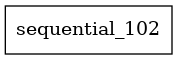

In [20]:
keras.utils.plot_model(best_model, "my_first_model.png")

In [22]:
history =best_model.fit(train_dataset, epochs=1)
test_dataset = get_test_dataset()
score = best_model.evaluate(test_dataset, verbose = 1) 
print('Test accuracy:', score[1])

1/1 [==============================] - 0s 14ms/step - loss: 0.5268 - accuracy: 0.8444
Test accuracy: 0.8444444537162781
